<a href="https://colab.research.google.com/github/Iceegan/BayesianAnomalyDetection/blob/master/RTLabAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#run this cell in colab
%%capture
!pip install --upgrade pymc3

In [3]:
# Run this cell on colab
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib
import pymc3 as pm
import matplotlib.pyplot as plt
import os
import numpy as np

# Collect the data

Data is for event specified by the `event` variable

In [0]:
os.chdir('/content/drive/My Drive/ExtractedZoneN/Results/')

In [0]:
event1Bus = pd.read_csv('B7Grounding_abcFault/buses.csv', index_col='time')[['B7VA_Mag', 'B1VA_Mag']]
event2Bus = pd.read_csv('L59Grounding_abfault/buses.csv', index_col='time')[['B5VA_Mag', 'B8VA_Mag']]
event3Bus=pd.read_csv('L59LineOpen_abcFault/buses.csv', index_col='time')[['B5VA_Mag', 'B8VA_Mag']]
event4Bus=pd.read_csv('MachineLossM1_abc/buses.csv', index_col='time')[['B1VA_Mag', 'B9VA_Mag']]

event1Freq = pd.read_csv('B7Grounding_abcFault/freq.csv', index_col='time')[['SM1wm', 'SM10wm']]
event2Freq = pd.read_csv('B7Grounding_abcFault/freq.csv', index_col='time')[['SM1wm', 'SM10wm']]
event3Freq = pd.read_csv('B7Grounding_abcFault/freq.csv', index_col='time')[['SM1wm', 'SM10wm']]
event4Freq = pd.read_csv('B7Grounding_abcFault/freq.csv', index_col='time')[['SM1wm', 'SM10wm']]

event1 = pd.concat([event1Bus, event1Freq], axis=1)
event2 = pd.concat([event2Bus, event2Freq], axis=1)
event3 = pd.concat([event3Bus, event3Freq], axis=1)
event4 = pd.concat([event4Bus, event4Freq], axis=1)



Add Noise and resample the data to Data

In [0]:
def addNoise(df, std=0.02):
  return df + np.random.normal(0, std, df.shape)

def resample(df, factor=50):
  # max_index = df.index[-1]
  # min_index = df.index[0]
  df = df.groupby(np.arange(len(df.index))//factor).mean()
  # df.index = df.index/df.index[-1]*max_index
  return df

event1 = resample(event1)
event1 = addNoise(event1)
event2 = resample(event2)
event2 = addNoise(event2)
event3 = resample(event3)
event3 = addNoise(event3)
event4 = resample(event4)
event4 = addNoise(event4)

In [0]:
step_size = event1.index[1]

In [0]:
train_start = 125
anom_start = 501
normal_data = event1['B1VA_Mag'][train_start:anom_start]

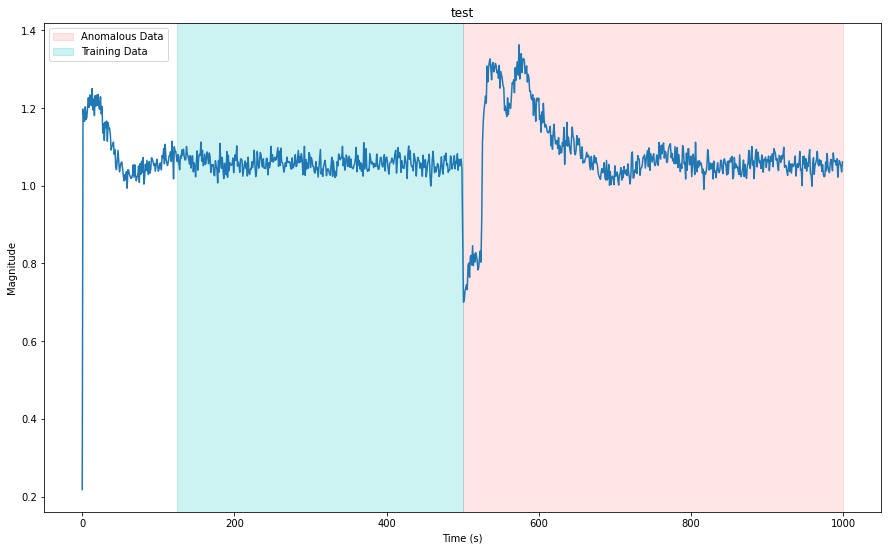

In [13]:
def prep_data(ser, title, train_start=2.5, train_stop=9, anom_end=1000):
  normal_data = ser[train_start:train_stop]
  # Get the first 2 seconds and last 5 seconds
  fig, ax = plt.subplots(1,1, figsize = (15,9))
  plt.title(title)
  plt.plot(ser.index, ser)
  ax.axvspan(train_stop, anom_end, alpha = 0.1, color = 'r', label = 'Anomalous Data')
  ax.axvspan(train_start, train_stop, alpha=0.2,color='c', label = 'Training Data')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Magnitude')
  ax.legend()
  plt.show()

# Comment if you don't want to shorten the data set
# pmu1B = pmu1B.groupby(np.arange(len(filteredData))//factor).mean()
prep_data(event1['B1VA_Mag'], 'test', train_start,anom_start)

# Create the AR model and sample it

In [0]:
def getARTrace(normal_data, reg_order=10):
  AR_Model = pm.Model()
  with AR_Model:
      data = pm.Data('data', normal_data)
      rho=pm.Uniform('rho',-5,5,shape=reg_order)
      tau =pm.Gamma('tau',mu=1,sd=1)
      obs=pm.AR('observed',rho=rho,tau=tau,observed=data)
      trace=pm.sample(1000, tune=2000)
  return trace

In [0]:
train_start = 125
anom_start = 501

In [0]:
import pickle

event1Trace = {}
for column in event1.columns:
  normal_data = event1[column][train_start:anom_start]
  trace = getARTrace(normal_data)
  event1Trace[column] = trace

with open('event1traces.pickle', 'wb') as file:
            pickle.dump((event1Trace), file)

event2Trace = {}
for column in event2.columns:
  normal_data = event2[column][train_start:anom_start]
  trace = getARTrace(normal_data)
  event2Trace[column] = trace

with open('event2traces.pickle', 'wb') as file:
            pickle.dump((event2Trace), file)

event3Trace = {}
for column in event3.columns:
  normal_data = event3[column][train_start:anom_start]
  trace = getARTrace(normal_data)
  event3Trace[column] = trace

with open('event3traces.pickle', 'wb') as file:
            pickle.dump((event3Trace), file)

event4Trace = {}
for column in event4.columns:
  normal_data = event4[column][train_start:anom_start]
  trace = getARTrace(normal_data)
  event3Trace[column] = trace

with open('event4traces.pickle', 'wb') as file:
            pickle.dump((event4Trace), file)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, rho]
Sampling chain 0, 0 divergences:  28%|██▊       | 837/3000 [01:17<04:04,  8.85it/s]

In [0]:
with open('event1traces.pickle', 'rb') as file:
  event1TracePickle = pickle.load(file)

In [0]:
trace = event1TracePickle['B7VA_Mag']


In [241]:
event1Trace

{'B7VA_Mag': <MultiTrace: 2 chains, 1000 iterations, 4 variables>}

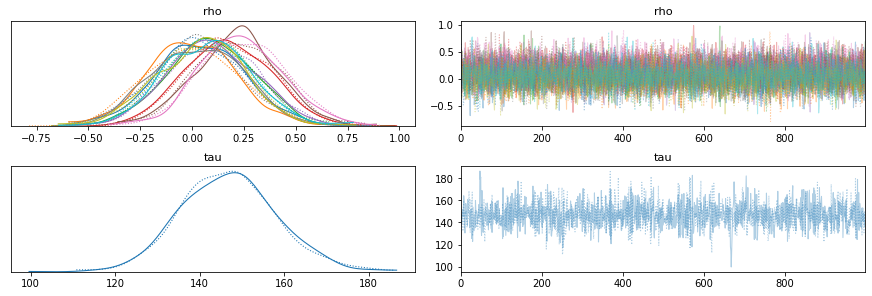

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.035   0.218   -0.369    0.452  ...   879.0    1982.0    1321.0    1.0
rho[1]    0.003   0.218   -0.377    0.436  ...   763.0    1657.0    1259.0    1.0
rho[2]    0.089   0.210   -0.296    0.476  ...   961.0    2561.0    1511.0    1.0
rho[3]    0.173   0.206   -0.190    0.573  ...  1242.0    2116.0    1146.0    1.0
rho[4]    0.100   0.212   -0.293    0.483  ...  1210.0    1953.0    1434.0    1.0
rho[5]    0.212   0.205   -0.158    0.606  ...  1748.0    2259.0    1303.0    1.0
rho[6]    0.242   0.205   -0.132    0.628  ...  1602.0    1930.0    1295.0    1.0
rho[7]    0.026   0.216   -0.366    0.433  ...  1038.0    1922.0    1298.0    1.0
rho[8]    0.044   0.214   -0.355    0.427  ...   955.0    1994.0    1375.0    1.0
rho[9]    0.074   0.210   -0.314    0.456  ...  1174.0    2026.0    1344.0    1.0
tau     146.898  11.204  125.250  167.475  ...  1994.0    2012.0    1181.0    1.0

[11 rows x 11 c

In [242]:
pm.traceplot(trace)
plt.show()
print(pm.summary(trace))

Add the functions for predicting y(t) and graphing the prediction

In [0]:
"""
predict_AR function
trace: The trace that contains the AR parameters to use
horizon (int): how many time steps foward you would like to predict
y_initial (Series): the initial values for y to be used by the algorithm. Length of this is regression order
returns: a numpy array with one row per sample in the trace, one column per time value in horizon
"""

def predict_AR(trace, horizon, y_initial):
    rho = trace['rho'] # might need to reverse this
    order = len(y_initial)
    num_points = len(list(enumerate(trace.points())))
    y_t = np.zeros((num_points, horizon + order))
    y_t[:,0:order] = np.tile(y_initial,(num_points,1))
    for i in range(order,horizon+order):
        y_t[:,i] = np.sum(y_t[:,i-order:i]*rho,axis=1)
    return y_t[:,order-1:]

"""
get_percentile_df
turns a 5xN array of percentile values into a dataframe 
"""
def get_percentile_df(prediction):
    percentiles = np.percentile(prediction,[2.5,25,50,75,97.5],axis=0)
    # Put in a dataframe for easier access
    percentile_df = pd.DataFrame(
        {'5th Percentile': percentiles[0],
         '25th Percentile': percentiles[1],
         'Median': percentiles[2],
         '75th Percentile': percentiles[3],
         '95th Percentile': percentiles[4],
         'Mean': np.mean(prediction,axis=0)
        })
    return percentile_df

def plot_distribution_prediction(observed, percentile_df,ratio=1):
    fig,ax = plt.subplots(1,1,figsize=(15,9))
    ax.plot(observed.index*ratio,observed)
    ax.plot(percentile_df.index*ratio,percentile_df['Median'],alpha=0.75,color='k',label='Posterior median')
    ax.fill_between(percentile_df.index*ratio,percentile_df['5th Percentile'],percentile_df['95th Percentile'],alpha=0.5,color='c',label='Center 95%')
    ax.fill_between(percentile_df.index*ratio,percentile_df['25th Percentile'],percentile_df['75th Percentile'],alpha=0.2,color='b',label='Center 50%')
    ax.axvline(x=observed.index[-1]*ratio,linestyle='--',color='r', alpha=0.5, label = 'End of training data')
    ax.legend()
    ax.set_xlim(observed.index[0]*ratio,percentile_df.index[-1]*ratio)
    ax.set_xlabel('Time')
    ax.set_ylabel('Magnitude')
    ax.set_title('Prediction of Current Magnitude')
    return fig, ax

def find_anomaly_index(actual, percentile_df):
    for idx in percentile_df.index:
        obs = actual.loc[idx]
        p95 = percentile_df.loc[idx]['95th Percentile']
        p5 = percentile_df.loc[idx]['5th Percentile']

        if obs < p5 or obs > p95:
            return idx

    return None
            

# Predict for future time steps and graph it

In [0]:
#Get a prediction for the next step_horizon periods
step_horizon = 10
prediction = predict_AR(trace,step_horizon,normal_data.iloc[-reg_order:])
# prediction = predict_AR(trace,step_horizon,normal_data.iloc[anom_start-reg_order:anom_start])
# Get the percentiles for the prediction and reindex for graphing
percentile_df = get_percentile_df(prediction)
percentile_df.index = percentile_df.index + normal_data.index[-1]

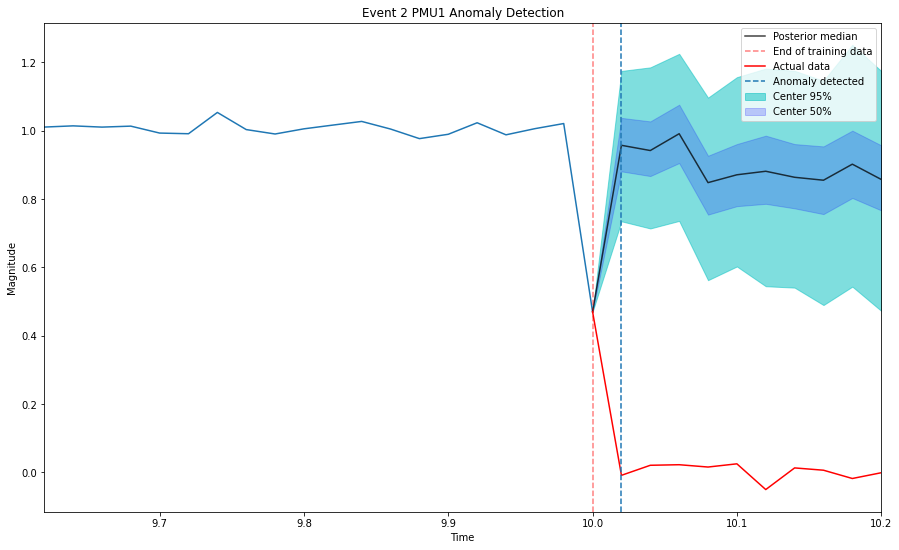

In [245]:
ratio = 1/50

# Plot the predicted data
fig, ax = plot_distribution_prediction(normal_data.iloc[-20:],percentile_df, ratio=ratio)

# Plot the actual data not used in the training
ax.plot(event1['B7VA_Mag'].index[anom_start-1:anom_start+step_horizon]*ratio,
        event1['B7VA_Mag'].iloc[anom_start-1:anom_start+step_horizon],
        label='Actual data',
        color = 'r')
ax.set_title('Event {} PMU1 Anomaly Detection'.format(2))
# ax.set_ylim([-0.25,0.1])

#Find and plot the location of the first detected anomaly
anom_loc = find_anomaly_index(event1['B7VA_Mag'],percentile_df)
if anom_loc is not None:
    plt.axvline(x=anom_loc*ratio, label = 'Anomaly detected', linestyle = '--')
else:
    print('No Anomalies detected')
ax.legend()

The anomaly is detected at around 170. Let's see what time that is in seconds

In [199]:
print('Anomaly detected at iloc[{0}], or {1}s'.format(anom_loc, anom_loc/1000*20))

Anomaly detected at iloc[501], or 10.02s


In [207]:
type(trace)

pymc3.backends.base.MultiTrace

B7VA_Mag
B1VA_Mag
SM1wm
SM10wm


In [224]:
event1trace = {}
normal_data = event1[column][train_start:anom_start]
trace = getARTrace(normal_data)
event1Trace[column] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, rho]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [04:59<00:00, 10.00it/s]


In [235]:
column

'B7VA_Mag'

In [0]:
trace = event1Trace['B7VA_Mag']

In [234]:
event1['B1VA_Mag'].index[anom_start-1:anom_start+step_horizon]*ratio

Float64Index([              10.0,              10.02, 10.040000000000001,
                           10.06,              10.08,               10.1,
              10.120000000000001,              10.14,              10.16,
                           10.18, 10.200000000000001],
             dtype='float64')